# Crack Detection in Concrete using CNN Models



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing required dependencies

In [3]:
!pip install wandb onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [4]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import wandb
import onnx
import matplotlib.pyplot as plt
import zipfile

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
config = dict(
    epochs=20,
    classes=2,
    batch_size=128,
    learning_rate=0.001,
    )

Extracting the dataset

In [8]:
with zipfile.ZipFile("drive/MyDrive/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

 Defining the overall pipeline for the classification

In [9]:
def model_pipeline(hyperparameters):

    with wandb.init(project="Crack Detection", config=hyperparameters):
      config = wandb.config

      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      train(model, train_loader, criterion, optimizer, config)

      test(model, test_loader)

    return model

Function that returns the data loaders, model, criterion and optimizer

In [10]:
def make(config):
    full_sub_data = get_data(slice=1)
    train_size = int(0.8 * len(full_sub_data)) # 184 images
    test_size = len(full_sub_data) - train_size # 46 images
    train, test = torch.utils.data.random_split(full_sub_data, [train_size, test_size])

    train_loader = make_loader(train, batch_size=config['batch_size'])
    test_loader = make_loader(test, batch_size=config['batch_size'], shuffle=False)

    model = ConvNet().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=config['learning_rate'])

    return model, train_loader, test_loader, criterion, optimizer

 Uploading the data, applying transformations and defining the dataloader

In [11]:
def get_data(slice=5):

    data_dir = 'dataset'

    transform = transforms.Compose([
    transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

    data = datasets.ImageFolder(os.path.join(data_dir, 'Decks'), transform=transform)
    # data += datasets.ImageFolder(os.path.join(data_dir, 'Pavements'), transform=transform)
    # data += datasets.ImageFolder(os.path.join(data_dir, 'Walls'), transform=transform)

    sub_dataset = torch.utils.data.Subset(data, indices=range(0, len(data), slice))


    return sub_dataset


def make_loader(dataset, batch_size, shuffle=True):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size,
                                         shuffle=shuffle,
                                         pin_memory=True,
                                         num_workers=2)
    return loader

Defining the class of the convolutional network

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(1, 16, 3, 1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(32*110*110, 128)
      self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

my_nn = ConvNet()
print(my_nn)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=387200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Specifying the training process, the wandb function comes into play: wandb.watch will log the gradients and the parameters

In [13]:
def train(model, loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config['epochs']
    example_ct = 0
    batch_ct = 0
    for epoch in tqdm(range(config['epochs'])):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images = torch.mean(images, dim=1, keepdim=True)
    images, labels = images.to(device), labels.to(device)

    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

wandb.log passes the metrics obtained during the training to the server  

In [14]:
def train_log(loss, example_ct, epoch):
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

Once the model is done training, we run it against some test data.

In [15]:
def test(model, test_loader):
    model.eval()

    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images = torch.mean(images, dim=1, keepdim=True)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")

        wandb.log({"test_accuracy": correct / total})

    # Save the model in ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

Get specific images from the dataset

In [16]:
def get_images(num_images):
    model, train_loader, test_loader, criterion, optimizer = make(config)
    for images, labels in train_loader:
        for i in range(num_images):
            plt.subplot(3, 3, i+1)
            plt.subplots_adjust(bottom=0.5, right=0.8, top=2)
            plt.imshow(transforms.ToPILImage()(images[i]))
            if labels[i] == 1:
                plt.xlabel('Image is not cracked')
            else:
                plt.xlabel('Image is cracked')
        break
        plt.show()


#### Total images





In [17]:
image_dataset = get_data(slice=1)
total_images = len(image_dataset)

print("The dataset contains",total_images, "images")

The dataset contains 13620 images


Classes and images per class

In [20]:
def get_counts():

    all_data = get_data(slice = 1)

    Decks = all_data.dataset.datasets[0].datasets[0]
    D_NC = Decks.targets.count(1)
    D_C = Decks.targets.count(0)

    Pavements = all_data.dataset.datasets[0].datasets[1]
    P_NC = Pavements.targets.count(1)
    P_C = Pavements.targets.count(0)

    Walls = all_data.dataset.datasets[-1]
    W_NC = Walls.targets.count(1)
    W_C = Walls.targets.count(0)

    return D_NC, D_C, P_NC, P_C, W_NC, W_C

def plot_histogram():

    Class = ["D_NC", "D_C", "P_NC", "P_C", "W_NC", "W_C"]
    D_NC, D_C, P_NC, P_C, W_NC, W_C = get_counts()
    Counts = [D_NC, D_C, P_NC, P_C, W_NC, W_C]

    fig, ax = plt.subplots()
    index = np.arange(len(Class))
    bar_width = 0.35

    for i in range(len(Class)):
        rects = np.empty(len(Class), dtype=object)

        if i%2==0:
            c = 'blue'
        else:
            c = 'red'
        rects[i] = ax.bar(index[i], Counts[i], bar_width, color=c, alpha=0.5)


    ax.set_xlabel('Class')
    ax.set_ylabel('Sample Counts')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(Class)
    ax.legend()

    plt.show()

In [22]:
# plot_histogram()

The dataset contains 6 classes. Firstly, it is divided into three classes: Decks, Pavements and Walls. It is then divided into cracked and non-cracked sub-category for each of the previous classes.

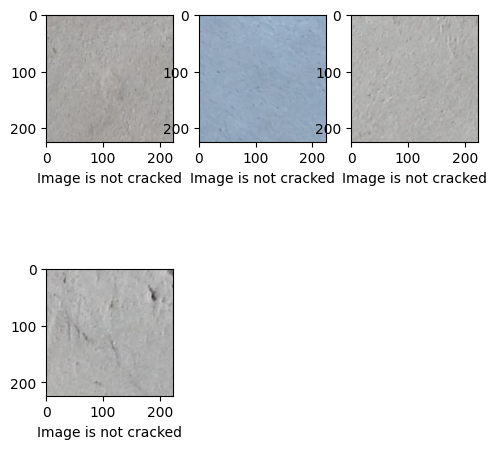

In [23]:
get_images(4)

In [ ]:
model = model_pipeline(config)

wandb: Currently logged in as: nagarpalikaishere. Use `wandb login --relogin` to force relogin


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=387200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss after 03072 examples: 0.486
Loss after 06272 examples: 0.507
Loss after 09472 examples: 0.461
Loss after 12560 examples: 0.448
Loss after 15760 examples: 0.444
Loss after 18960 examples: 0.347
Loss after 22048 examples: 0.379
Loss after 25248 examples: 0.450
Loss after 28448 examples: 0.389
Loss after 31648 examples: 0.461
Loss after 34736 examples: 0.500
Loss after 37936 examples: 0.558
Loss after 41136 examples: 0.481
Loss after 44224 examples: 0.510
Loss after 47424 examples: 0.509
Loss after 50624 examples: 0.398
Loss after 53824 examples: 0.527
Loss after 56912 examples: 0.365
Loss after 60112 examples: 0.593
Loss after 63312 examples: 0.467
Loss after 66400 examples: 0.454
Loss after 69600 examples: 0.424
Loss after 72800 examples: 0.379
Loss after 76000 examples: 0.453
